# Inpainting

## Set Up

In [9]:
from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from IPython.display import clear_output

model_id = "google/ddpm-celebahq-256"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load model and scheduler
unet = UNet2DModel.from_pretrained(model_id).to(device)

c:\Users\Usuario\anaconda3\envs\synthetic\Lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


## Simple Denoising

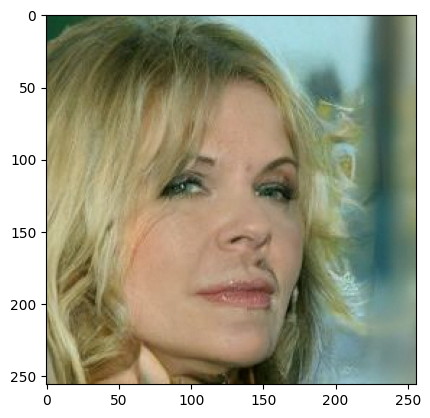

In [2]:
torch.manual_seed(1)

unet = unet.to(device)
xt = torch.randn(1, 3, 256, 256).to(device)

scheduler = DDIMScheduler(beta_start=0.0001, beta_end=0.02, beta_schedule="linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

# sample from the model
unet.eval()

# Denoising Loop
for t in tqdm(scheduler.timesteps, total=scheduler.num_inference_steps, leave=False):
    with torch.no_grad():
        # Pred the noise
        noise_pred = unet(xt, t.to(device)).sample
    
    # To denoise
    xt = scheduler.step(noise_pred, t.to(device), xt).prev_sample

plt.imshow(xt.squeeze().permute(1, 2, 0).cpu().numpy()*0.5 + 0.5)
plt.show()

## Load the Image

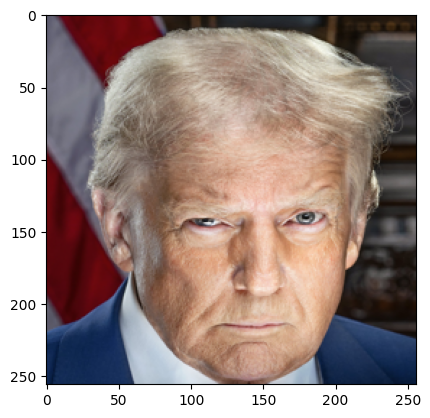

In [3]:
from PIL import Image
import numpy as np
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

ref_image = Image.open("data/dt.png").crop((300, 200, 2200, 2300)).resize((256, 256)).convert("RGB")
ref_image = transform(ref_image).unsqueeze(0).to(device)

plt.imshow(ref_image.squeeze().permute(1, 2, 0).cpu().numpy()*0.5 + 0.5)
plt.show()

## Create a Mask

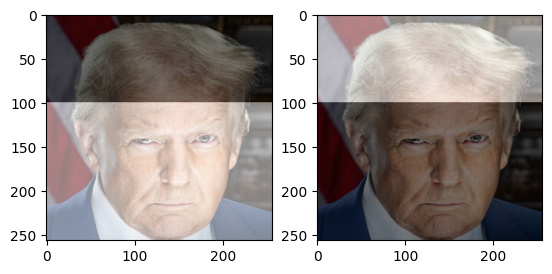

In [6]:
import numpy as np
from scipy.ndimage import gaussian_filter

mask = np.ones((256, 256), dtype=np.float32)
mask[0:100, :] = 0.0

# Apply Gaussian smoothing
# mask = gaussian_filter(mask, sigma=5)

# Convert to torch tensor
mask = torch.from_numpy(mask).to(device)

# Compute inverse mask
inv_mask = 1.0 - mask

# Plot the mask and inv mask
plt.subplot(1, 2, 1)
plt.imshow(ref_image.squeeze().permute(1, 2, 0).cpu().numpy()*0.5+0.5)
plt.imshow(mask.squeeze().cpu().numpy(), cmap="grey", alpha=0.5)

plt.subplot(1, 2, 2)
plt.imshow(ref_image.squeeze().permute(1, 2, 0).cpu().numpy()*0.5+0.5)
plt.imshow(inv_mask.squeeze().cpu().numpy(), cmap="grey", alpha=0.5)

## Repaint

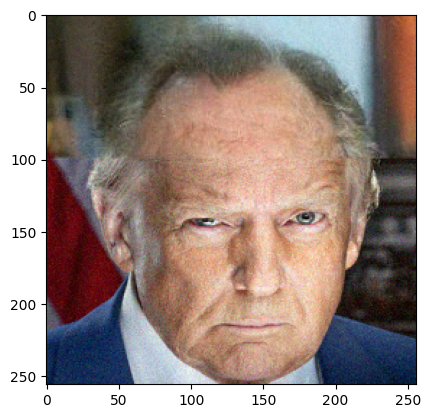

In [14]:
xt = torch.randn(1, 3, 256, 256).to(device)
torch.manual_seed(1)

# Denoising Loop
for t in tqdm(scheduler.timesteps, total=scheduler.num_inference_steps, leave=False):

    with torch.no_grad():
        noise_pred = unet(xt, t.to(device)).sample
    xt = scheduler.step(noise_pred, t.to(device), xt).prev_sample

    # add noise to the ref image
    noise = torch.randn_like(ref_image).to(device)
    x_noised = scheduler.add_noise(ref_image, noise, t.to(device))

    xt = xt * inv_mask[None, None, :, :] + x_noised * mask[None, None, :, :]

    if t%50:
        plt.imshow(xt.squeeze().permute(1, 2, 0).cpu().numpy()*0.5+0.5)
        clear_output(wait=True)
        plt.show()

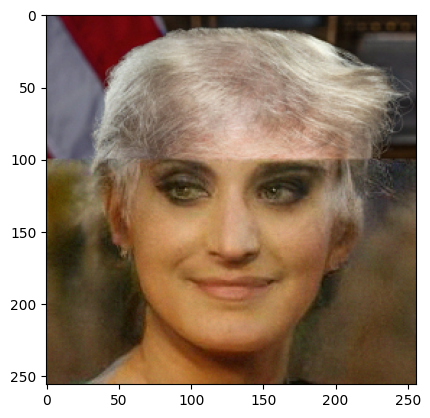

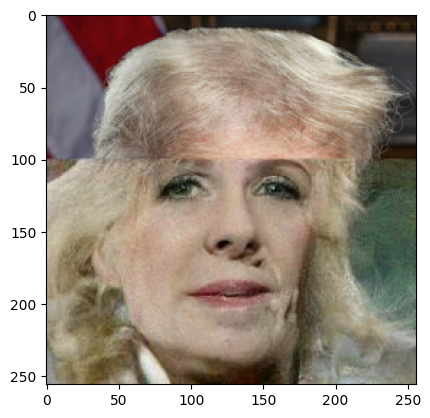

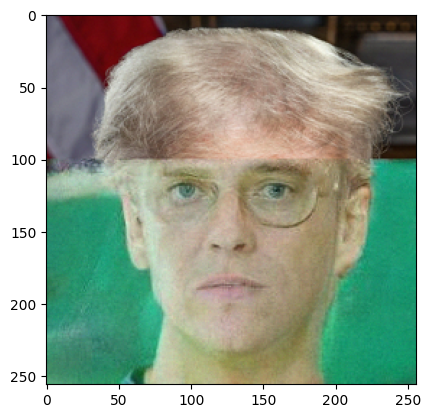

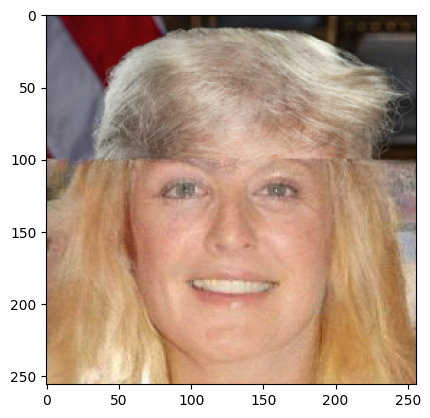

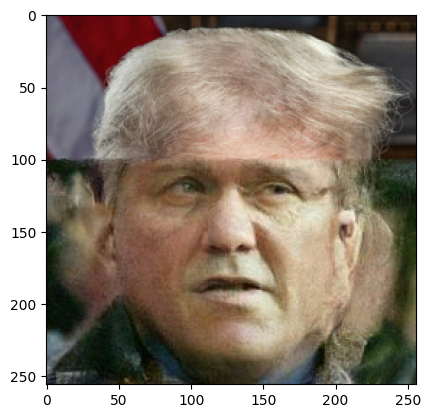

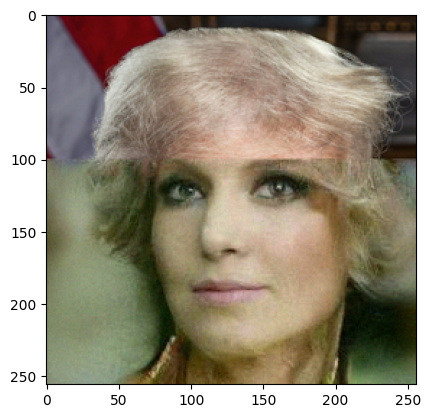

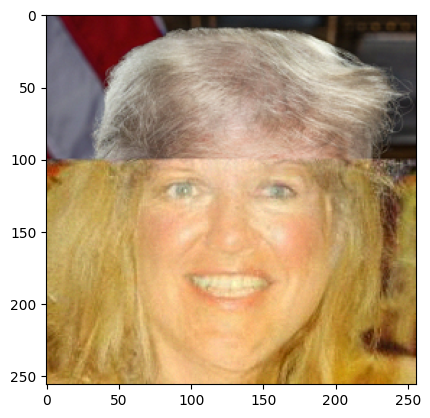

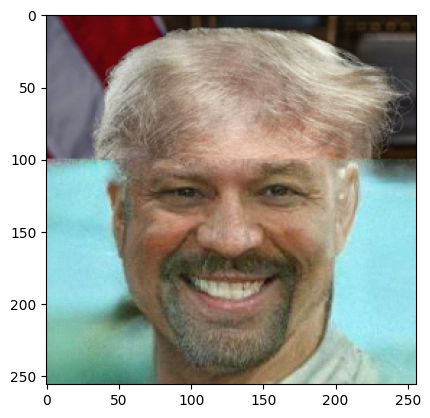

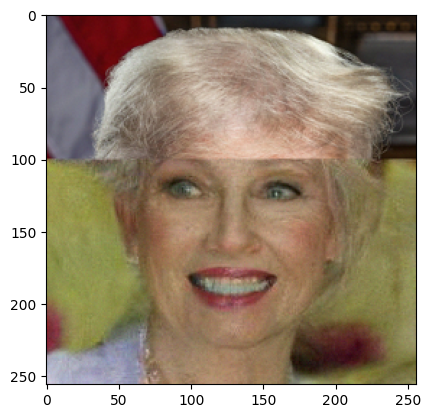

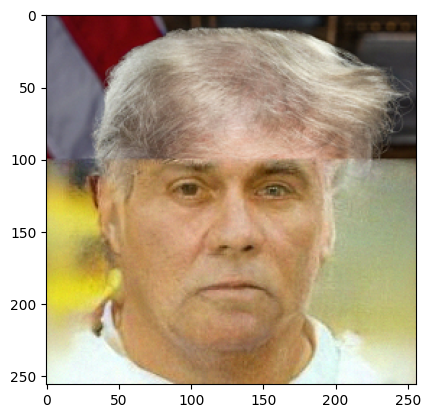

In [15]:
for seed in range(10):
    torch.manual_seed(seed=seed)

    # sample random noise
    xt = torch.randn(1, 3, 256, 256).to(device)

    # Denoising Loop
    for t in tqdm(scheduler.timesteps, total=scheduler.num_inference_steps, leave=False):

        with torch.no_grad():
            noise_pred = unet(xt, t.to(device)).sample
        xt = scheduler.step(noise_pred, t.to(device), xt).prev_sample

        # add noise to the ref image
        noise = torch.randn_like(ref_image).to(device)
        x_noised = scheduler.add_noise(ref_image, noise, t.to(device))

        xt = xt*mask[None, None, :, :] + x_noised*inv_mask[None, None, :, :]

    plt.imshow(xt.squeeze().permute(1, 2, 0).cpu().numpy()*0.5+0.5)
    plt.show()

# Image Compositing